<a href="https://colab.research.google.com/github/sfwtopoulos/stocks/blob/master/Stocks_seq_1st.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import math
import warnings
import numpy as np
import time

import pandas_datareader as pdr
#%tensorflow_version 2.x
# Restart runtime using 'Runtime' -> 'Restart runtime...'
%tensorflow_version 1.x
import tensorflow as tf
import keras


from keras.layers import LSTM
from keras.models import Sequential
from keras.layers.wrappers import TimeDistributed
from keras.layers.core import Dense, Activation, Dropout
from keras.preprocessing.sequence import pad_sequences

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
#not all needed


warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [79]:
print(keras.__version__)
print(tf.__version__)
#print(tensorflow.compat.v2.__version__)

2.2.5
1.15.0


In [0]:
#Data import from git repo
url = 'https://raw.githubusercontent.com/sfwtopoulos/stocks/master/stocks_dataset/combined.csv'
#df1 = pd.read_csv(url, error_bad_lines=False)
dfstocks = pd.read_csv(url, sep=',')

In [81]:
#fix column names
dfstocks=dfstocks.rename({' AAPL':'Company', ' Close/Last':'Close', ' Volume':'Volume', ' Open':'Open', ' High':'High', ' Low':'Low'}, axis=1);
for col in dfstocks.columns: 
    print(col) 

Date
Close
Volume
Open
High
Low
Company


In [0]:
#drop $sign from values
dfstocks.Close=dfstocks['Close'].astype(str)
dfstocks.Close=dfstocks.Close.apply(lambda x: x.replace('$',''))
dfstocks.Open=dfstocks['Open'].astype(str)
dfstocks.Open=dfstocks.Open.apply(lambda x: x.replace('$',''))
dfstocks.High=dfstocks['High'].astype(str)
dfstocks.High=dfstocks.High.apply(lambda x: x.replace('$',''))
dfstocks.Low=dfstocks['Low'].astype(str)
dfstocks.Low=dfstocks.Low.apply(lambda x: x.replace('$',''))

In [83]:
#drop rows containing nan or header from the csv files
dfstocks=dfstocks[~dfstocks.Low.str.contains("nan")]
dfstocks=dfstocks[~dfstocks.Low.str.contains("Low")]
dfstocks=dfstocks[~dfstocks.Low.str.contains("N/A")]
dfstocks=dfstocks[~dfstocks.Volume.str.contains("N/A")]
dfstocks.reset_index(drop=True, inplace=True)
dfstocks.Date.count()

229269

In [84]:
#sort dataframe based on date and Company Name
dfstocks = dfstocks.sort_values(['Date', 'Company'])
dfstocks.head(100)

,Date,Close,Volume,Open,High,Low,Company
1761,01/02/2013,78.4328,139906732,79.1171,79.2857,77.3757,AAPL
4248,01/02/2013,35.12,13767660,34.92,35.4,34.1,ABBV
6025,01/02/2013,32.05,20266410,32.3,32.45,31.64,ABT
8512,01/02/2013,69.06,4039095,67.59,69.06,67.55,ACN
10999,01/02/2013,38.34,6483720,37.92,38.73,37.92,ADBE
...,...,...,...,...,...,...,...
10747,01/02/2014,59.29,2745895,59.06,59.53,58.94,ADBE
13234,01/02/2014,168.05,1268722,167.33,170.71,166.5937,AGN
15721,01/02/2014,50.71,9196092,50.81,51.3,50.47,AIG
18208,01/02/2014,53.55,1909106,54.09,54.45,53.5,ALL


In [0]:
#Test Split
dfstocks_split = dfstocks.sample(frac=0.9998,random_state=200)
second_split=dfstocks.drop(dfstocks_split.index)
# second_split = second_split.reindex(index=second_split.Date(second_split.index.min(), 
#                                           second_split.index.max(), 
#                                           freq='D')).fillna(method='ffill')


In [86]:
#Converting Datatypes
dfstocks.Date=pd.to_datetime(dfstocks.Date)
dfstocks.Close=pd.to_numeric(dfstocks.Close)
dfstocks.Volume=pd.to_numeric(dfstocks.Volume)
dfstocks.Open=pd.to_numeric(dfstocks.Open)
dfstocks.High=pd.to_numeric(dfstocks.High)
dfstocks.Low=pd.to_numeric(dfstocks.Low)
dfstocks.dtypes

Date       datetime64[ns]
Close             float64
Volume              int64
Open              float64
High              float64
Low               float64
Company            object
dtype: object

In [87]:
#dfstocks[dfstocks['Company'].str.contains("AMZN")]
second_split=dfstocks[dfstocks['Company'].str.contains("AMZN")]
second_split.isnull().values.any()
second_split.isna().values.any()
second_split = second_split.sort_values(['Date'])
second_split.reset_index(drop=True, inplace=True)
second_split.shape[0]

2487

In [89]:
second_split

,Date,Close,Volume,Open,High,Low,Company
0,2010-02-16,117.53,8899183,120.060,120.50,117.180,AMZN
1,2010-02-17,116.31,8913604,117.075,117.13,115.550,AMZN
2,2010-02-18,118.08,9795116,115.839,118.51,114.820,AMZN
3,2010-02-19,117.52,7114712,117.910,119.09,117.000,AMZN
4,2010-02-22,118.01,6806986,117.370,118.97,116.180,AMZN
...,...,...,...,...,...,...,...
2482,2019-12-24,1789.21,881337,1793.810,1795.57,1787.575,AMZN
2483,2019-12-26,1868.77,6024608,1801.010,1870.46,1799.500,AMZN
2484,2019-12-27,1869.80,6188754,1882.920,1901.40,1866.010,AMZN
2485,2019-12-30,1846.89,3677306,1874.000,1884.00,1840.620,AMZN


In [0]:
TRAIN_PERCENT = 0.7
#STOCK_INDEX = '^GSPC'
VERBOSE=True

In [0]:
# prepare training and testing data sets for LSTM based sequence modeling
#def get_seq_train_test(time_series, scaling=True,train_size=0.9):
def get_seq_train_test(time_series,train_size=0.9):
    # scaler = None
    # if scaling:
    #     scaler = MinMaxScaler(feature_range=(0, 1))
    time_series = np.array(time_series).reshape(-1,1)
    #     scaled_stock_series = scaler.fit_transform(time_series)
    # else:
    #     scaled_stock_series = time_series
    scaled_stock_series = time_series
        
    #train_size = int(len(scaled_stock_series) * train_size)
    train_size = int(len(time_series) * train_size)

    #train = scaled_stock_series[0:train_size]
    train = time_series[0:train_size]
    #test = scaled_stock_series[train_size:len(scaled_stock_series)]
    test = time_series[train_size:len(time_series)]
    
    return train,test 


In [0]:
def get_seq_model(hidden_units=4,input_shape=(1,1),verbose=False):
    # create and fit the LSTM network
    model = Sequential()
    # samples*timesteps*featuress

    model.add(LSTM(input_shape=input_shape,
                   units = hidden_units,
                   return_sequences=True
    ))

    # readout layer. TimeDistributedDense uses the same weights for all
    # time steps.
    model.add(TimeDistributed(Dense(1)))
    start = time.time()

    model.compile(loss="mse", optimizer="rmsprop")

    if verbose:
        print("> Compilation Time : ", time.time() - start)
        print(model.summary())

    return model

In [93]:
# split train and test datasets
train,test = get_seq_train_test(second_split.Close,
#                                  scaling=True,
                                   train_size=TRAIN_PERCENT)

#train
print(len(train))
print(train.shape[0])
print(train.shape)
print(test.shape)

1740
1740
(1740, 1)
(747, 1)


In [94]:
#We use numpy to reshape our time seriesinto 3D tensors.
train = np.reshape(train,(1,train.shape[0],1))
test = np.reshape(test,(1,test.shape[0],1))

train_x = train[:,:-1,:]
train_y = train[:,1:,:]

test_x = test[:,:-1,:]
test_y = test[:,1:,:]

print("Data Split Complete")

print("train_x shape={}".format(train_x.shape))
print("train_y shape={}".format(train_y.shape))
print("test_x shape={}".format(test_x.shape))
print("test_y shape={}".format(test_y.shape))

Data Split Complete
train_x shape=(1, 1739, 1)
train_y shape=(1, 1739, 1)
test_x shape=(1, 746, 1)
test_y shape=(1, 746, 1)


In [95]:
# build RNN model
seq_lstm_model=None
try:
    seq_lstm_model = get_seq_model(input_shape=(train_x.shape[1],1),
                                                verbose=VERBOSE)
except:
    print("Model Build Failed. Trying Again")
    seq_lstm_model = get_seq_model(input_shape=(train_x.shape[1],1),
                                                verbose=VERBOSE)

> Compilation Time :  0.021636486053466797
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 1739, 4)           96        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 1739, 1)           5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________
None


In [96]:
# train the model
seq_lstm_model.fit(train_x, train_y,
                #epochs=150, batch_size=1,
                epochs=3, batch_size=1,
                verbose=2)
print("Model Fit Complete")

Epoch 1/3
 - 1s - loss: 154102.3750
Epoch 2/3
 - 1s - loss: 154100.2031
Epoch 3/3
 - 1s - loss: 154098.6250
Model Fit Complete


In [97]:
# train fit performance
trainPredict = seq_lstm_model.predict(train_x)
trainScore = math.sqrt(mean_squared_error(train_y[0], trainPredict[0]))
print('Train Score: %.2f RMSE' % (trainScore))

Train Score: 392.55 RMSE


In [98]:
trainPredict

array([[[0.00737736],
        [0.00737736],
        [0.00737736],
        ...,
        [0.00737736],
        [0.00737736],
        [0.00737736]]], dtype=float32)

In [0]:
# Pad input sequence
testPredict = pad_sequences(test_x,maxlen=train_x.shape[1],padding='post',dtype='float64')

In [0]:
# forecast values
testPredict = seq_lstm_model.predict(testPredict)

In [0]:
# forecast values
testPredict = seq_lstm_model.predict(testPredict)

In [0]:
# # inverse transformation
# scaler = MinMaxScaler(feature_range=(0, 1))
# trainPredict = scaler.inverse_transform(trainPredict.\
#                                         reshape(trainPredict.shape[1]))
# testPredict = scaler.inverse_transform(testPredict.\
#                                         reshape(testPredict.shape[1]))

trainPredict=trainPredict.reshape(trainPredict.shape[1])
testPredict=testPredict.reshape(testPredict.shape[1])


In [113]:
trainPredict

array([0.00737736, 0.00737736, 0.00737736, ..., 0.00737736, 0.00737736,
       0.00737736], dtype=float32)

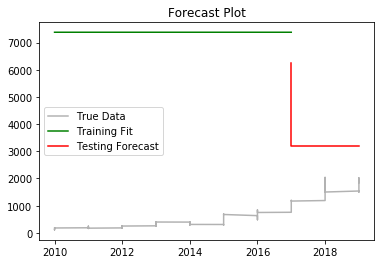

In [116]:
# plot the true and forecasted values
train_size = len(trainPredict)+1

plt.plot(second_split.Date.dt.year,
          second_split.Close.values,c='black',
          alpha=0.3,label='True Data')
plt.plot(second_split.Date.dt.year[1:train_size],
          trainPredict*1000000,label='Training Fit',c='g')
plt.plot(second_split.Date.dt.year[train_size+1:],
          testPredict[:test_x.shape[1]]*1000000,label='Testing Forecast',c='r')
plt.title('Forecast Plot')
plt.legend()
plt.show()

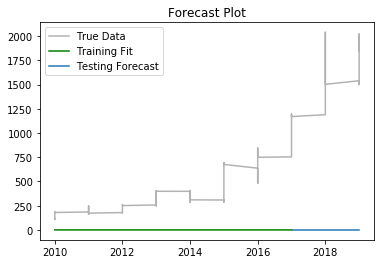

In [105]:
# plot the true and forecasted values
train_size = len(trainPredict)+1
#second_split.Date.dt.year
# plt.plot(second_split.index,
#           second_split.Close.values,c='black',
#           alpha=0.3,label='True Data')
plt.plot(second_split.Date.dt.year,
          second_split.Close.values,c='black',
          alpha=0.3,label='True Data')
plt.plot(second_split.Date.dt.year[1:train_size],
          trainPredict,label='Training Fit',c='g')
plt.plot(second_split.Date.dt.year[train_size+1:],
          testPredict[:test_x.shape[1]],label='Testing Forecast')
plt.title('Forecast Plot')
plt.legend()
plt.show()

In [0]:

# df['date'] = pd.to_datetime(df['date'])
# df['year'], df['month'] = df['date'].dt.year, df['date'].dt.month
# df
#type(second_split)
